# Scikit-Learn Modeling

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import metrics
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from time import time

In [13]:
# Load in data
df = pd.read_csv('cleaned_bullying.csv')

In [14]:
# Set prediction columns
pred_cols = ['Bullied_on_school_property_in_past_12_months',
             'Bullied_not_on_school_property_in_past_12_months',
             'Cyber_bullied_in_past_12_months',
             'bullied']
Y = df[pred_cols]

# Set predictor columns
X = df.drop(columns=pred_cols)
X = X.drop(columns='Unnamed: 0')

In [15]:
# Create function to calculate and plot AUC
def AUC(y_test, y_pred, plot=None):
    
    # Calculate true positive and false positive rates
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)

    # Calculate AUC
    auc = metrics.roc_auc_score(y_test, y_pred)

    # Plot ROC curve if specified
    if plot is not None:
        x = np.linspace(0, 1, 101)
        y = np.linspace(0, 1, 101)
        plt.plot(x, y, '--', color='r')
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve, AUC={auc}')
        plt.grid()

    return auc

In [16]:
# Create function to evaluate a given model for a certain target variable
def evaluate(y, model, plot_auc=None, plot_cm=None):

    # Start timing
    start = time()

    # Calculate and print baseline accuracy rate
    # achieved by predicting more common class
    vc_0, vc_1 = y.value_counts().values
    frac = vc_0 / (vc_0 + vc_1)
    if frac < 0.5:
        frac = 1 - frac
    frac = round(frac*100, 5)
    print(f'BASELINE ACCURACY: {frac}%')
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

    # Set model
    if model == 'logistic_regression':
        model = LogisticRegression(solver='liblinear')
    elif model == 'decision_tree':
        model = DecisionTreeClassifier(random_state=13)
    elif model == 'svm':
        model = svm.SVC()
    elif model == 'random_forest':
        model = RandomForestClassifier(random_state=13)
    elif model == 'xgboost':
        model = xgb.XGBClassifier()

    # Fit model and make predictions
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    if plot_auc is None:
        auc = AUC(y_test, y_pred, plot=None)
    else:
        auc = AUC(y_test, y_pred, plot=True)

    if plot_cm is None:
        pass
    else:
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()
        #ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

    end = time()
    time_diff = end - start

    print(f'Evaluation metrics for\n{model}\npredicting: {y.name}\n')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1-score: {f1}')
    print(f'AUC: {auc}')
    print(f'-----TOTAL TIME: {time_diff}-----')

BASELINE ACCURACY: 59.36305%


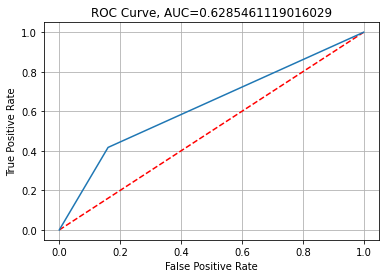

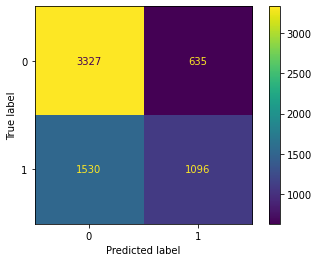

Evaluation metrics for
LogisticRegression(solver='liblinear')
predicting: bullied

Accuracy: 0.6713721918639951
Precision: 0.63316002310803
Recall: 0.4173648134044174
F1-score: 0.5030984622446638
AUC: 0.6285461119016029
-----TOTAL TIME: 0.3368971347808838-----


In [17]:
evaluate(y=Y['bullied'],
         model=LogisticRegression(solver='liblinear'),
         plot_auc=True,
         plot_cm=True)

In [18]:
# Evaluate all models (for any bullying)
model_list = ['logistic_regression',
              'decision_tree',
              'svm',
              'random_forest',
              'xgboost']

for model_i in model_list:
    evaluate(y=Y['bullied'],
         model=model_i)
    print('')

BASELINE ACCURACY: 59.36305%
Evaluation metrics for
LogisticRegression(solver='liblinear')
predicting: bullied

Accuracy: 0.6713721918639951
Precision: 0.63316002310803
Recall: 0.4173648134044174
F1-score: 0.5030984622446638
AUC: 0.6285461119016029
-----TOTAL TIME: 0.09439730644226074-----

BASELINE ACCURACY: 59.36305%
Evaluation metrics for
DecisionTreeClassifier(random_state=13)
predicting: bullied

Accuracy: 0.6246205221615058
Precision: 0.5355648535564853
Recall: 0.43869002284843867
F1-score: 0.48231107389575045
AUC: 0.5932723208638963
-----TOTAL TIME: 0.06874537467956543-----

BASELINE ACCURACY: 59.36305%
Evaluation metrics for
SVC()
predicting: bullied

Accuracy: 0.666970248937462
Precision: 0.6534090909090909
Recall: 0.3503427265803503
F1-score: 0.4561229548834903
AUC: 0.613586305238686
-----TOTAL TIME: 38.14194202423096-----

BASELINE ACCURACY: 59.36305%
Evaluation metrics for
RandomForestClassifier(random_state=13)
predicting: bullied

Accuracy: 0.6311475409836066
Precision: 0

In [19]:
# Evaluate all models (for bullying at school)
for model_i in model_list:
    evaluate(y=Y['Bullied_on_school_property_in_past_12_months'],
         model=model_i)
    print('')

BASELINE ACCURACY: 79.14263%
Evaluation metrics for
LogisticRegression(solver='liblinear')
predicting: Bullied_on_school_property_in_past_12_months

Accuracy: 0.8022161505768063
Precision: 0.4971751412429379
Recall: 0.06758832565284179
F1-score: 0.11899932386747802
AUC: 0.5253756989596029
-----TOTAL TIME: 0.11612796783447266-----

BASELINE ACCURACY: 79.14263%
Evaluation metrics for
DecisionTreeClassifier(random_state=13)
predicting: Bullied_on_school_property_in_past_12_months

Accuracy: 0.7443837279902854
Precision: 0.3288530465949821
Recall: 0.2818740399385561
F1-score: 0.3035566583953681
AUC: 0.5700894982136973
-----TOTAL TIME: 0.08237099647521973-----

BASELINE ACCURACY: 79.14263%
Evaluation metrics for
SVC()
predicting: Bullied_on_school_property_in_past_12_months

Accuracy: 0.8026715239829993
Precision: 0.6
Recall: 0.004608294930875576
F1-score: 0.009146341463414635
AUC: 0.5019257895388393
-----TOTAL TIME: 25.54489493370056-----

BASELINE ACCURACY: 79.14263%
Evaluation metrics fo

In [20]:
# Evaluate all models (for any bullying)
for model_i in model_list:
    evaluate(y=Y['Bullied_not_on_school_property_in_past_12_months'],
         model=model_i)
    print('')

BASELINE ACCURACY: 77.79768%
Evaluation metrics for
LogisticRegression(solver='liblinear')
predicting: Bullied_not_on_school_property_in_past_12_months

Accuracy: 0.7794474802671524
Precision: 0.5658536585365853
Recall: 0.07837837837837838
F1-score: 0.13768545994065282
AUC: 0.530477364600309
-----TOTAL TIME: 0.14375710487365723-----

BASELINE ACCURACY: 77.79768%
Evaluation metrics for
DecisionTreeClassifier(random_state=13)
predicting: Bullied_not_on_school_property_in_past_12_months

Accuracy: 0.7339101396478446
Precision: 0.37579617834394907
Recall: 0.27905405405405403
F1-score: 0.3202791779759597
AUC: 0.572377457723973
-----TOTAL TIME: 0.0784611701965332-----

BASELINE ACCURACY: 77.79768%
Evaluation metrics for
SVC()
predicting: Bullied_not_on_school_property_in_past_12_months

Accuracy: 0.7774741955069824
Precision: 0.6346153846153846
Recall: 0.0222972972972973
F1-score: 0.04308093994778068
AUC: 0.509288820927427
-----TOTAL TIME: 25.17152190208435-----

BASELINE ACCURACY: 77.79768%

In [21]:
# Evaluate all models (for any bullying)
for model_i in model_list:
    evaluate(y=Y['Cyber_bullied_in_past_12_months'],
         model=model_i)
    print('')

BASELINE ACCURACY: 77.59427%
Evaluation metrics for
LogisticRegression(solver='liblinear')
predicting: Cyber_bullied_in_past_12_months

Accuracy: 0.7799028536733454
Precision: 0.5422885572139303
Recall: 0.07430129516019086
F1-score: 0.13069544364508393
AUC: 0.5281680269981779
-----TOTAL TIME: 0.1392810344696045-----

BASELINE ACCURACY: 77.59427%
Evaluation metrics for
DecisionTreeClassifier(random_state=13)
predicting: Cyber_bullied_in_past_12_months

Accuracy: 0.7257134183363692
Precision: 0.3471223021582734
Recall: 0.2631220177232447
F1-score: 0.2993408297789841
AUC: 0.560676416008664
-----TOTAL TIME: 0.0771636962890625-----

BASELINE ACCURACY: 77.59427%


/Users/alexherron/opt/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation metrics for
SVC()
predicting: Cyber_bullied_in_past_12_months

Accuracy: 0.7773224043715847
Precision: 0.0
Recall: 0.0
F1-score: 0.0
AUC: 0.5
-----TOTAL TIME: 29.747720956802368-----

BASELINE ACCURACY: 77.59427%
Evaluation metrics for
RandomForestClassifier(random_state=13)
predicting: Cyber_bullied_in_past_12_months

Accuracy: 0.7557680631451124
Precision: 0.4060846560846561
Recall: 0.2092706203135651
F1-score: 0.2762033288349078
AUC: 0.5607962162298151
-----TOTAL TIME: 1.6335899829864502-----

BASELINE ACCURACY: 77.59427%
Evaluation metrics for
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256,